In [87]:

# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage import color
from scipy.cluster.hierarchy import dendrogram, linkage

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from PIL import Image

In [88]:
path = r"/Users/taylorlast/Documents/GitHub/elephent-footprints-VGG16/Elephant Prints copy"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
elephants = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
#         if file.name.endswith('.JPG'):
          # adds only the image files to the flowers list
        elephants.append(file.name)
elephants.remove('.png')
elephants

['Elephant 1 copy 2.JPG',
 'Elephant 13 copy 2.JPG',
 'Elephant 17 copy.JPG',
 'Elephant 16 copy.JPG',
 'Elephant 16 copy 2.JPG',
 'Elephant 8copy 2.JPG',
 'Elephant 9 copy 2.JPG',
 '.DS_Store',
 'Elephant 6 copy.JPG',
 'Elephant 7 copy.JPG',
 'Elephant 4 copy 2.JPG',
 'Elephant 2.JPG',
 'Elephant 15.JPG',
 'Elephant 1 copy.JPG',
 'Elephant 14.JPG',
 'Elephant 3.JPG',
 'Elephant 3 copy 2.JPG',
 'Elephant 1.JPG',
 'Elephant 16.JPG',
 'Elephant 17.JPG',
 'Elephant 11 copy 2.JPG',
 'Elephant 4.JPG',
 'Elephant 13.JPG',
 'Elephant 14 copy 2.JPG',
 'Elephant 12.JPG',
 'Elephant 5.JPG',
 'Elephant 7.JPG',
 'Elephant 10.JPG',
 'Elephant 6 copy 2.JPG',
 'Elephant 19 copy 2.JPG',
 'Elephant 11.JPG',
 'Elephant 6.JPG',
 'Elephant 10 copy.JPG',
 'Elephant 11 copy.JPG',
 'Elephant 20.JPG',
 'Elephant 20 copy 2.JPG',
 'Elephant 17 copy 2.JPG',
 'Elephant 4copy.JPG',
 'Elephant 8.JPG',
 'Elephant 5 copy 2.JPG',
 'Elephant 5 copy.JPG',
 'Elephant 9.JPG',
 'Elephant 14 copy.JPG',
 'Elephant 15 copy.JP

In [89]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

model.summary()
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [90]:

data = {}
p = r"/Users/taylorlast/Documents/UGA_FourthYear/STAT_5020/elephant_model.pkl"

# lop through each image in the dataset
for elephant in elephants:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(elephant,model)
        data[elephant] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

In [119]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

# get the unique labels (from the flower_labels.csv)
# df = pd.read_csv('flower_labels.csv')
# label = df['label'].tolist()
# unique_labels = list(set(label))

# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=15, random_state=22)
pca.fit(feat)
x = pca.transform(feat)
np.set_printoptions(suppress=True)
print(np.cumsum(pca.explained_variance_ratio_))
x.shape


[0.32435164 0.4485081  0.5320252  0.59341383 0.65412766 0.7024777
 0.7424978  0.7802471  0.8134965  0.8445621  0.868994   0.8923653
 0.9137816  0.93199134 0.9478415 ]


(60, 15)

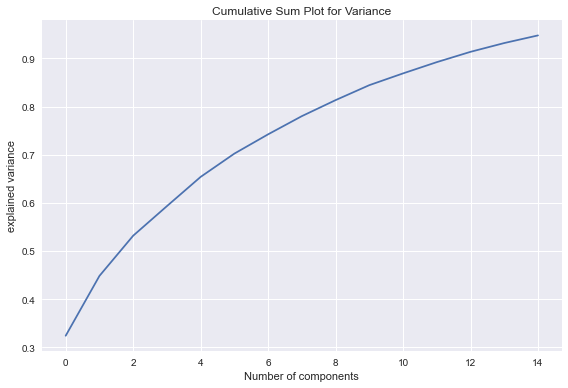

In [128]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Sum Plot for Variance')
plt.ylabel('explained variance')
plt.xlabel('Number of components')
plt.tight_layout()
plt.savefig('/Users/taylorlast/Documents/UGA_FourthYear/STAT_5020/cumsum_PCA_elephants.jpg')

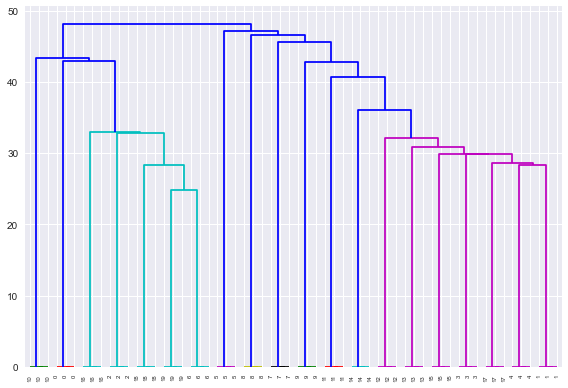

In [130]:
# cluster feature vectors
kmeans = KMeans(n_clusters=20, random_state=22)
kmeans.fit(x)
label = kmeans.fit_predict(x)

# ax = plt.axes(projection = '3d')
# plt.style.use('seaborn')

# for i in label:
#     temp = x[label == i]
#     ax.scatter3D(temp[0] , temp[1],  temp[2], cmap = 'red')

linked = linkage(x, 'single')


dendrogram(linked,
            orientation='top',
            labels=label,
            distance_sort='descending',
            show_leaf_counts=True)
plt.tight_layout()
plt.savefig('/Users/taylorlast/Documents/UGA_FourthYear/STAT_5020/dendrogram_elephants.jpg')


In [104]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
groups

{0: ['Elephant 1 copy 2.JPG', 'Elephant 1 copy.JPG', 'Elephant 1.JPG'],
 15: ['Elephant 13 copy 2.JPG', 'Elephant 13.JPG', 'Elephant 13 copy.JPG'],
 17: ['Elephant 17 copy.JPG', 'Elephant 17.JPG', 'Elephant 17 copy 2.JPG'],
 18: ['Elephant 16 copy.JPG', 'Elephant 16 copy 2.JPG', 'Elephant 16.JPG'],
 5: ['Elephant 8copy 2.JPG', 'Elephant 8.JPG', 'Elephant 8 copy.JPG'],
 2: ['Elephant 9 copy 2.JPG', 'Elephant 9.JPG', 'Elephant 9 copy.JPG'],
 6: ['Elephant 6 copy.JPG', 'Elephant 6 copy 2.JPG', 'Elephant 6.JPG'],
 8: ['Elephant 7 copy.JPG', 'Elephant 7.JPG', 'Elephant 7 copy 2.JPG'],
 12: ['Elephant 4 copy 2.JPG', 'Elephant 4.JPG', 'Elephant 4copy.JPG'],
 4: ['Elephant 2.JPG', 'Elephant 2 copy 2.JPG', 'Elephant 2 copy.JPG'],
 3: ['Elephant 15.JPG', 'Elephant 15 copy.JPG', 'Elephant 15 copy 2.JPG'],
 10: ['Elephant 14.JPG', 'Elephant 14 copy 2.JPG', 'Elephant 14 copy.JPG'],
 16: ['Elephant 3.JPG', 'Elephant 3 copy 2.JPG', 'Elephant 3 copy.JPG'],
 14: ['Elephant 11 copy 2.JPG', 'Elephant 11.

In [8]:
elephant_cluster_df = pd.DataFrame(data=groups).T
elephant_cluster_df.index.name = 'Cluster'
elephant_cluster_df.sort_values(by='Cluster')

,0,1,2
Cluster,,,
0,Elephant 1 copy 2.JPG,Elephant 1 copy.JPG,Elephant 1.JPG
1,Elephant 11 copy 2.JPG,Elephant 11.JPG,Elephant 11 copy.JPG
2,Elephant 17 copy.JPG,Elephant 17.JPG,Elephant 17 copy 2.JPG
3,Elephant 9 copy 2.JPG,Elephant 9.JPG,Elephant 9 copy.JPG
4,Elephant 15.JPG,Elephant 15 copy.JPG,Elephant 15 copy 2.JPG
5,Elephant 5.JPG,Elephant 5 copy 2.JPG,Elephant 5 copy.JPG
6,Elephant 13 copy 2.JPG,Elephant 13.JPG,Elephant 13 copy.JPG
7,Elephant 8copy 2.JPG,Elephant 8.JPG,Elephant 8 copy.JPG
8,Elephant 2.JPG,Elephant 2 copy 2.JPG,Elephant 2 copy.JPG


In [9]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [10]:
#this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 30))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
    km.fit(x)
    
    sse.append(km.inertia_)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.war

<ipython-input-10-55b59ed12683>:7: ConvergenceWarning: Number of distinct clusters (20) found smaller than n_clusters (29). Possibly due to duplicate points in X.
  km.fit(x)


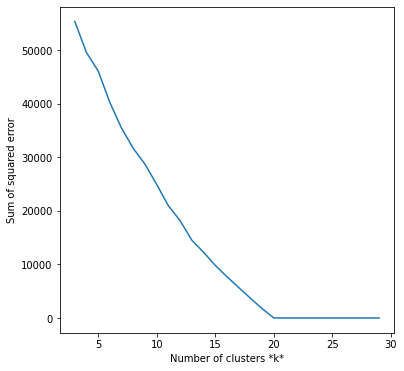

In [11]:
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared error');

plt.style.use('ggplot')
plt.savefig('/Users/taylorlast/Documents/UGA_FourthYear/STAT_5020/elephant_sse_example_20Clust.jpg',bbox_inches='tight')

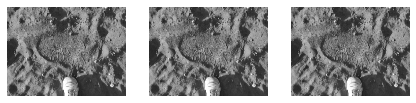

In [12]:
view_cluster(1)